# Task 2: Regression for $LiOH$

In [8]:
import warnings 
warnings.filterwarnings('ignore')
target = 'Future'
target_df =  transform_data("../Data/Lithium futures price.csv")

         Date       Open       High        Low      Close  Change %  Volume
0  2017-05-10 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
1  2017-05-11 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
2  2017-05-12 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
3  2017-05-15 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0
4  2017-05-16 136,000.00 140,000.00 132,000.00 136,000.00      0.00       0


Please enter the column names, separated by a comma:  Date,Open,High,Low,Price,Change,Vol


In [9]:
start_date = '2017-09-08'
end_date = '2023-08-07'

In [19]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import requests
import io
import yfinance as yf


from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

from dataloader import YahooDownloader

upstream_companies = pd.read_csv("../Data/Upstream_companies.csv")

In [20]:
def transform_data(file_path, sampling_period = 'W-FRI'): 
    
    '''
    This function transform the price into log return and output the weekly log return and price in a dataframe.
    '''

    outlier_cutoff = 0.01
    # read the data
    price = pd.read_csv(file_path)

    # print or inspect the DataFrame before renaming the columns
    print(price.head())

    # ask for the column names 
    column_names = input("Please enter the column names, separated by a comma: ").split(',')

    # strip any leading/trailing whitespace from the column names
    column_names = [name.strip() for name in column_names]

    # rename the columns 
    price.columns = column_names

    # transfer the date to date format 
    price['Date'] = pd.to_datetime(price['Date'])
    
    if (price['Price'].apply(type) == str).any():
        price['Price'] = price['Price'].str.replace(',', '', regex=True).astype(float)
    price.set_index('Date', inplace=True)

    # Resample to get the last business day's 'Close' price for each week.
    # 'W-FRI' denotes weeks ending on Friday.
    weekly_price = price['Price'].resample(sampling_period).last()

    # make the series a dataframe:
    weekly_price = pd.DataFrame(weekly_price)

    # Calculate log returns
    weekly_price['Log_Return'] = np.log(weekly_price["Price"]).diff().\
    pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_price = weekly_price.dropna()

    return weekly_price

def plot_correlogram(x, lags=None, title=None):
    '''
    Plot the series, QQ plot, ACF, PACF
    '''
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Series(residuals)')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        
        plot_acf(x=x, lags=lags, ax=axes[1][0])
        plot_pacf(x, lags=lags, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)
        
def ARIMA_Model_Fit(series, p,d,q, title):
    '''
    Fit the ARIMA model and output the residual of the model 
    '''
    plot_correlogram(series, lags = 50, title = "Before Modeling: " + title)
    model_price = tsa.ARIMA(series,order=(p,d,q)).fit()
    print(model_price.summary())
    plot_correlogram(model_price.resid, lags = 50, title = "After Modeling: "+ title)
    return model_price.resid

def get_data(start_date, end_date, ticker):
    if ticker.endswith('.US'):
        ticker = ticker.split('.')[0]
    downloader = YahooDownloader(start_date = start_date, end_date = end_date, ticker_list=[ticker])
    data = downloader.fetch_data()
    df = data[['date', 'close']].copy()
    df.columns = ['Date', 'Price']
    return df

def get_stock_data(ticker, start_date, end_date, sampling_period = 'W-FRI'):
    df = get_data(start_date, end_date, ticker)
    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = ['Date',"Asset_close"]
    df.set_index('Date', inplace=True)
    
    # find the original currency it has 
    from_currency = upstream_companies[upstream_companies.Stock == ticker].Currency.iloc[0]
    if from_currency != "CNY":
        ticker_symbol = from_currency + "CNY=X"
        print(ticker_symbol)
        exchange_rate = yf.download(ticker_symbol, start=start_date, end=end_date)
        exchange_rate = exchange_rate[[ "Adj Close"]]
        exchange_rate.columns = ["Exchange_rate"]
        exchange_rate.index = pd.to_datetime(exchange_rate.index)
        df = df.merge(exchange_rate, left_index=True, right_index=True)
        df["converted_close"] = df["Asset_close"]*df["Exchange_rate"]
        df = df[["converted_close"]]
        df.columns = ['Asset_close']
    
    # Resample to get the last business day's 'Close' price for each week.
    weekly_df = df['Asset_close'].resample(sampling_period).last()
    weekly_df = pd.DataFrame(weekly_df)
    weekly_df['Log_Return'] = np.log(weekly_df["Asset_close"]).diff()

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_df = weekly_df.dropna()
    return weekly_df

## Weekly Lithium Carbonate Price

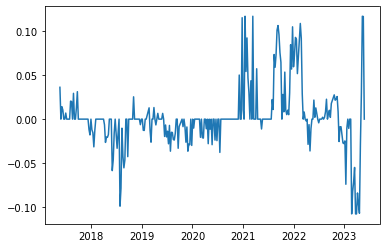

In [12]:
plt.plot(target_df.Log_Return)

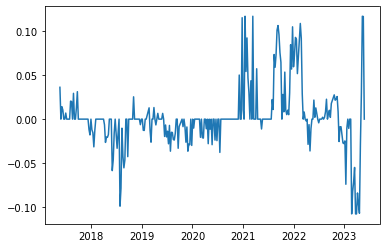

In [13]:
plt.plot(target_df[target_df.index>'2017'].Log_Return)

## Part 1)

In [21]:
def individual_company_concur(target_df, ticker, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date, sampling_period = 'W-FRI')
    
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Assest_LogReturn"]
    
    model = smf.ols('Li_LogReturn~ Assest_LogReturn', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'coefficient' : model.params['Assest_LogReturn'],
    'coefficient_pvalue' : model.pvalues['Assest_LogReturn'],
    'hac_standard_error' : model.bse['Assest_LogReturn']}
    
    return res

In [22]:
result1 = []

for ticker in upstream_companies.Stock:
    try:
        res = individual_company_concur(target_df, ticker, start_date, end_date)
    except Exception as e:
        res = {}
    res['ticker'] = ticker
    result1.append(res)

In [16]:
df_result1 = pd.DataFrame(result1)
df_result1.set_index('ticker', inplace=True)
df_result1.to_csv(f"result/{target}_task2_1.csv")

In [34]:
df_result1[df_result1.coefficient_pvalue<=0.05].sort_values("coefficient_pvalue")

,intercept,intercept_pvalue,coefficient,coefficient_pvalue,hac_standard_error
ticker,,,,,
WML.V,0.00,0.70,0.05,0.01,0.02
LITH.V,0.00,0.75,0.04,0.01,0.01
LAC,0.00,0.81,0.04,0.01,0.02
SYA.AX,0.00,0.83,0.03,0.02,0.01
SQM,0.00,0.78,0.06,0.02,0.03


In [ ]:
df = df_result1.copy().round(3)

# Function to color cells based on coefficient_pvalue
# Create a mask for the heatmap that sets everything to True (to hide all cells)
# Create a DataFrame for colors based on the coefficient_pvalue column
colors = df['coefficient_pvalue'].copy()
colors = [x if x<0.05 else 1 for x in colors]
colors = pd.DataFrame({'coefficient_pvalue': colors})
colors.index = df.index

for col in df.columns:
    if col != 'coefficient_pvalue':
        colors[col] = 1  # Assigning a high value to ensure a light color
        
colors = colors[['intercept', 'intercept_pvalue', 'coefficient','coefficient_pvalue',
       'hac_standard_error']].copy()

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(colors, annot=df.values, fmt='', cmap='ocean', ax=ax, cbar=False, linewidths=0.5, linecolor='black')

# Adjust the layout
plt.subplots_adjust(left=0.2, top=0.8)
plt.savefig(f'pictures/{target}_task2_1.png', dpi=300, bbox_inches='tight')

## Part 2) 

In [18]:
# Calculate moving averages for various lags
def individual_company_lag(target_df, ticker, lag, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date , sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Asset_LogReturn"]
    merged_df['Asset_Lag'] = merged_df['Asset_LogReturn'].rolling(window = lag).mean().shift(1)
    model = smf.ols('Li_LogReturn~ Asset_Lag', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'lag_coefficient' : model.params['Asset_Lag'],
    'lag_coefficient_pvalue' : model.pvalues['Asset_Lag'],
    'hac_standard_error' : model.bse['Asset_Lag']}
    
    return res


In [23]:
result = []

for ticker in upstream_companies.Stock:
    for lag in range(1,5):
        try:
            res = individual_company_lag(target_df, ticker, lag = lag, start_date = start_date, end_date= end_date)
        except Exception as e:
            res = {}
        res['ticker'] = ticker
        res['lag'] = lag
        result.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)


In [24]:
df_result2 = pd.DataFrame(result)
df_result2 = df_result2.set_index(['ticker', 'lag'])
df_result2.to_csv(f"result/{target}_task2_2.csv")

In [35]:
df_result2.loc[df_result2.lag_coefficient_pvalue <= 0.05]

intercept  intercept_pvalue  lag_coefficient  \
ticker    lag                                                 
002176.SZ 1         0.00              0.75             0.08   
          2         0.00              0.77             0.12   
          3         0.00              0.77             0.17   
          4         0.00              0.76             0.21   
AKE.AX    3         0.00              0.90             0.12   
          4         0.00              0.95             0.19   
ALL.L     3         0.00              0.80             0.12   
          4         0.00              0.81             0.15   
ERA.PA    1         0.00              0.78             0.05   
          2         0.00              0.81             0.08   
          3         0.00              0.82             0.11   
          4         0.00              0.83             0.15   
LITH.V    4         0.00              0.69             0.12   
LPI.AX    4         0.00              0.72             0.11   
PLS.AX    1         0.00              0.87             0.05   
          2         0.00              0.95             0.09   
          3        -0.00              0.96             0.14   
          4        -0.00              0.87             0.20   
SYA.AX    4         0.00              0.96             0.07   

               lag_coefficient_pvalue  hac_standard_error  
ticker    lag                                              
002176.SZ 1                      0.00                0.03  
          2                      0.01                0.05  
          3                      0.00                0.06  
          4                      0.00                0.07  
AKE.AX    3                      0.04                0.06  
          4                      0.01                0.07  
ALL.L     3                      0.04                0.06  
          4                      0.02                0.06  
ERA.PA    1                      0.03                0.02  
          2                      0.01                0.03  
          3                      0.01                0.04  
          4                      0.00                0.05  
LITH.V    4                      0.02                0.05  
LPI.AX    4                      0.04                0.06  
PLS.AX    1                      0.02                0.02  
          2                      0.01                0.04  
          3                      0.00                0.05  
          4                      0.00                0.06  
SYA.AX    4                      0.04                0.04

## Part3) 

In [26]:
def individual_company_concur_lag1(target_df, ticker, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date, sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Assest_LogReturn"]
    merged_df['Lithium_lag1'] = merged_df['Li_LogReturn'].shift(1)
    model = smf.ols('Li_LogReturn~ Assest_LogReturn + Lithium_lag1', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'asset_coefficient' : model.params['Assest_LogReturn'],
    'asset_coefficient_pvalue' : model.pvalues['Assest_LogReturn'],
    'asset_hac_standard_error' : model.bse['Assest_LogReturn'],
    'lithium_lag1_coefficient' : model.params['Lithium_lag1'],
    'lithium_lag1_coefficient_pvalue' : model.pvalues['Lithium_lag1'],
    'lithium_lag1_hac_standard_error' : model.bse['Lithium_lag1']}
    
    return res

In [27]:
result3_1 = []

for ticker in upstream_companies.Stock:
    try:
        res = individual_company_concur_lag1(target_df, ticker,  start_date = start_date, end_date= end_date)
    except Exception as e:
        res = {}
    res['ticker'] = ticker
    result3_1.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
AUDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
USDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1491, 8)
GBpCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complet

In [28]:
df_result3_1 = pd.DataFrame(result3_1)
df_result3_1 = df_result3_1.set_index('ticker')
df_result3_1.to_csv(f"result/{target}_task2_3(1).csv")

In [36]:
df_result3_1.loc[(df_result3_1.asset_coefficient_pvalue <= 0.05)][['asset_coefficient',
       'asset_coefficient_pvalue', 'asset_hac_standard_error',
       'lithium_lag1_coefficient', 'lithium_lag1_coefficient_pvalue',
       'lithium_lag1_hac_standard_error']]

,asset_coefficient,asset_coefficient_pvalue,asset_hac_standard_error,lithium_lag1_coefficient,lithium_lag1_coefficient_pvalue,lithium_lag1_hac_standard_error
ticker,,,,,,
AMLI,0.02,0.03,0.01,0.68,0.00,0.07
LAC,0.04,0.01,0.02,0.68,0.00,0.07
LTHM,0.04,0.02,0.02,0.69,0.00,0.07
PLS.AX,0.04,0.01,0.01,0.67,0.00,0.07


In [30]:
def individual_company_lag_lag1(target_df, ticker, lag, start_date = '2017-09-08', end_date = '2023-08-07'):
    stock_data = get_stock_data(ticker, start_date = start_date, end_date = end_date, sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Asset_LogReturn"]
    merged_df['Lithium_lag1'] = merged_df['Li_LogReturn'].shift(1)
    merged_df['Asset_Lag'] = merged_df['Asset_LogReturn'].rolling(window = lag).mean().shift(1)
    model = smf.ols('Li_LogReturn~ Asset_Lag + Lithium_lag1', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'asset_lag_coefficient' : model.params['Asset_Lag'],
    'asset_lag_coefficient_pvalue' : model.pvalues['Asset_Lag'],
    'asset_lag_hac_standard_error' : model.bse['Asset_Lag'],
    'lithium_lag1_coefficient' : model.params['Lithium_lag1'],
    'lithium_lag1_coefficient_pvalue' : model.pvalues['Lithium_lag1'],
    'lithium_lag1_hac_standard_error' : model.bse['Lithium_lag1']}
    
    return res

In [31]:
result3_2 = []

for ticker in upstream_companies.Stock:
    for lag in range(1,5):
        try:
            res = individual_company_lag_lag1(target_df, ticker, lag = lag, start_date = start_date, end_date= end_date)
        except Exception as e:
            res = {}
        res['ticker'] = ticker
        res['lag'] = lag
        result3_2.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)


In [32]:
df_result3_2 = pd.DataFrame(result3_2)
df_result3_2 = df_result3_2.set_index(["ticker", "lag"])

In [33]:
df_result3_2.to_csv(f"result/{target}_task2_3(2).csv")
df_result3_2.head()

intercept  intercept_pvalue  asset_lag_coefficient  \
ticker    lag                                                       
002176.SZ 1         0.00              0.81                   0.06   
          2         0.00              0.85                   0.04   
          3         0.00              0.81                   0.08   
          4         0.00              0.81                   0.08   
002460.SZ 1         0.00              0.84                   0.02   

               asset_lag_coefficient_pvalue  asset_lag_hac_standard_error  \
ticker    lag                                                               
002176.SZ 1                            0.01                          0.02   
          2                            0.13                          0.03   
          3                            0.03                          0.03   
          4                            0.06                          0.04   
002460.SZ 1                            0.38                          0.02   

               lithium_lag1_coefficient  lithium_lag1_coefficient_pvalue  \
ticker    lag                                                              
002176.SZ 1                        0.67                             0.00   
          2                        0.66                             0.00   
          3                        0.66                             0.00   
          4                        0.65                             0.00   
002460.SZ 1                        0.67                             0.00   

               lithium_lag1_hac_standard_error  
ticker    lag                                   
002176.SZ 1                               0.07  
          2                               0.07  
          3                               0.07  
          4                               0.07  
002460.SZ 1                               0.07

In [37]:
df_result3_2.loc[(df_result3_2.asset_lag_coefficient_pvalue <= 0.05)][['asset_lag_coefficient',
       'asset_lag_coefficient_pvalue', 'asset_lag_hac_standard_error',
       'lithium_lag1_coefficient', 'lithium_lag1_coefficient_pvalue',
       'lithium_lag1_hac_standard_error']]

asset_lag_coefficient  asset_lag_coefficient_pvalue  \
ticker    lag                                                        
002176.SZ 1                     0.06                          0.01   
          3                     0.08                          0.03   
AKE.AX    4                     0.08                          0.02   
ALL.L     3                     0.06                          0.04   
          4                     0.06                          0.04   
ERA.PA    4                     0.07                          0.03   
LEL.AX    1                     0.04                          0.05   
PLS.AX    3                     0.06                          0.02   
          4                     0.09                          0.00   

               asset_lag_hac_standard_error  lithium_lag1_coefficient  \
ticker    lag                                                           
002176.SZ 1                            0.02                      0.67   
          3                            0.03                      0.66   
AKE.AX    4                            0.04                      0.66   
ALL.L     3                            0.03                      0.66   
          4                            0.03                      0.66   
ERA.PA    4                            0.03                      0.67   
LEL.AX    1                            0.02                      0.79   
PLS.AX    3                            0.03                      0.66   
          4                            0.03                      0.65   

               lithium_lag1_coefficient_pvalue  \
ticker    lag                                    
002176.SZ 1                               0.00   
          3                               0.00   
AKE.AX    4                               0.00   
ALL.L     3                               0.00   
          4                               0.00   
ERA.PA    4                               0.00   
LEL.AX    1                               0.00   
PLS.AX    3                               0.00   
          4                               0.00   

               lithium_lag1_hac_standard_error  
ticker    lag                                   
002176.SZ 1                               0.07  
          3                               0.07  
AKE.AX    4                               0.07  
ALL.L     3                               0.07  
          4                               0.07  
ERA.PA    4                               0.07  
LEL.AX    1                               0.07  
PLS.AX    3                               0.07  
          4                               0.07